# 1. Chargement des librairies et données

## 1.1. Import des librairies

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

## 1.2. Import des données

In [217]:
dataset = pd.read_csv("./dataset/insurance.csv")
df = pd.DataFrame(dataset)

display(df.head())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1.3. Vérification des données

In [218]:
print(" Nombre de lignes dupliquées : ", df.duplicated().sum(), "\n")

display(df[df.duplicated(keep=False)])

df = df.drop_duplicates()
print("\n→ Doublon supprimé")

print("\nDonnées manquantes :")
display(df.isna().sum())
print("\n→ Pas de données manquantes")

 Nombre de lignes dupliquées :  1 



,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631



→ Doublon supprimé

Données manquantes :


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


→ Pas de données manquantes


## 1.4. Feature engineering

In [219]:
df["obese"] = (df["bmi"].map(lambda x: "no" if x < 30 else "yes"))

display(df.head())

,age,sex,bmi,children,smoker,region,charges,obese
0,19,female,27.900,0,yes,southwest,16884.92400,no
1,18,male,33.770,1,no,southeast,1725.55230,yes
2,28,male,33.000,3,no,southeast,4449.46200,yes
3,33,male,22.705,0,no,northwest,21984.47061,no
4,32,male,28.880,0,no,northwest,3866.85520,no


# 2. Modélisation automatisée (modèle basique)

__linearRegression(), pas de feature engineering, split test-train__

## 2.1. Split test-train

In [220]:
def split_data_test_train(df):
    X = df.drop("charges", axis=1)
    y = df["charges"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size = 0.2,
        random_state = 42
    )

    return X_train, X_test, y_train, y_test

## 2.2. Sauvegarde et chargement de modèle

In [221]:
def save_model(name, pipeline):
    filename = f"./models/{name}.pkl"
    joblib.dump(pipeline, open(filename, "wb")) # write in binary, overrides if file already exists


def load_model(name_ext):
    filename = f"./models/{name_ext}"
    loaded_model = joblib.load(open(filename, "rb")) # read binary file
    return loaded_model

## 2.3. Transformation des données

In [222]:
def transform_columns(X_set):
    cat_cols = X_set.select_dtypes(include="object").columns.tolist()
    num_cols = X_set.select_dtypes(include=["float64", "int64"]).columns.tolist()


    scaler = ColumnTransformer(transformers = [("ohe_sex_smoker_children", OneHotEncoder(drop="first"), cat_cols),
                                                    ("standard_age_bmi_children", StandardScaler(), num_cols)
                                                    ])

    return scaler


def apply_pipeline(X_train, y_train, name):

    scaler = transform_columns(X_train)

    pipeline = Pipeline([
        ("scaler", scaler),
        ("regressor", LinearRegression())
    ])

    pipeline.fit(X_train, y_train)

    save_model(name, pipeline)

    return pipeline


## 2.4. Évaluation et visualisation des prédictions

In [223]:
def make_predictions(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred


def visualise_predictions(y_test, y_pred, r2):
    plt.figure(figsize=(10, 6))

    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors="k", linewidth=0.5, label="Prédictions")

    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             "r-", lw=2, label="Régression parfaite")

    plt.xlabel("Valeurs réelles", fontsize=12)
    plt.ylabel("Valeurs prédites", fontsize=12)
    plt.title(f"Régression linéaire (précision : {r2 * 100:.2f} %)", fontsize=12, fontweight="bold")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def evaluate_model(y_test, y_pred):
    titles = ["R2", "MAE", "MSE"]

    r2 = r2_score(y_test, y_pred)

    scores = [
        r2,
        np.mean(np.abs(y_test - y_pred)),
        (mean_squared_error(y_test, y_pred)) ** 0.5
    ]

    df_scores = pd.DataFrame([scores], columns=titles)

    print(f"\nMesures de performance :")
    
    display(df_scores.round(4))

    return r2


def run_model(model, X_test, y_test):
    y_pred = make_predictions(model, X_test)

    r2 = evaluate_model(y_test, y_pred)

    visualise_predictions(y_test, y_pred, r2)


## 2.5. Exécution du modèle


Mesures de performance :


,R2,MAE,MSE
0,0.8129,4137.1863,5863.0129


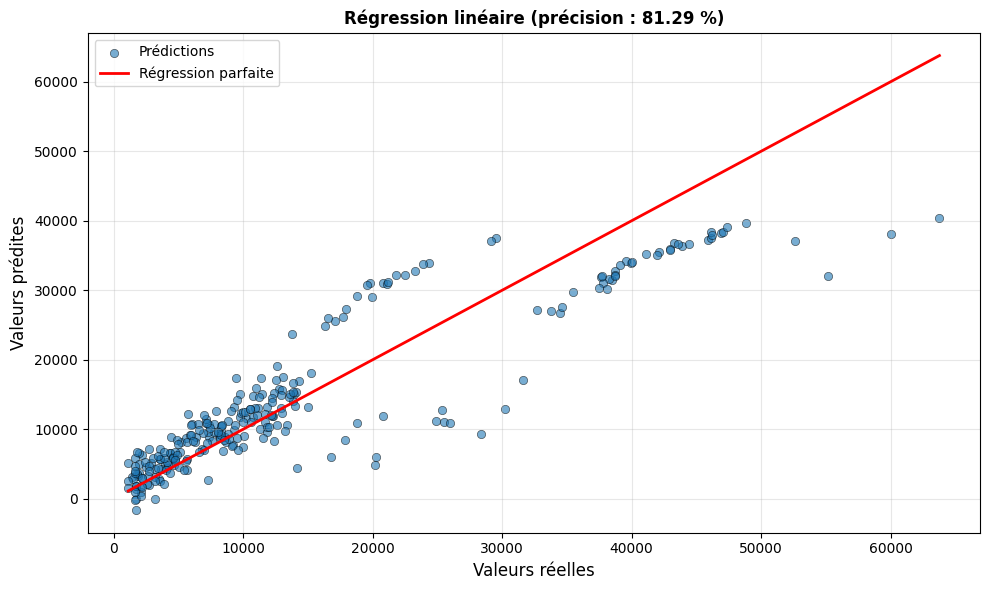

In [ ]:
def linear_regression(df, name, load=False):

    X_train, X_test, y_train, y_test = split_data_test_train(df)

    model = load_model(name) if load else apply_pipeline(X_train, y_train, name)

    run_model(model, X_test, y_test)


df_basic = df.copy()

# Première exécution et sauvegarde
linear_regression(df_basic, "linear_regression_basic_1")

# Chargement de modèle existant
# linear_regression(df_basic, "linear_regression_basic_1.pkl", True)

# 3. Améliorations : cross validation

__Améliorations à mettre en place :__
- cross validation (cross_val_score ou GridSearchCV)
- polynomial features
- choix du modèle (Ridge, Lasso, ElasticNet)

## 3.1. Modèle basique avec cross_val_score

In [225]:
from sklearn.model_selection import cross_val_score

def transform_columns(features):
    cat_cols = features.select_dtypes(include="object").columns.tolist()
    num_cols = features.select_dtypes(include=["float64", "int64"]).columns.tolist()


    scaler = ColumnTransformer(transformers = [("ohe_sex_smoker_children", OneHotEncoder(drop="first"), cat_cols),
                                                    ("standard_age_bmi_children", StandardScaler(), num_cols)
                                                    ])


    return scaler



def apply_pipeline_crossval(features):

    scaler = transform_columns(features)

    pipeline = Pipeline([
        ("scaler", scaler),
        ("regressor", LinearRegression())
    ])

    return pipeline


def run_cross_validation(df):

    features = df.drop("charges", axis=1)
    target = df["charges"]

    pipeline = apply_pipeline_crossval(features)

    scores = cross_val_score(
        estimator = pipeline,
        X = features, # inputs features
        y = target, # output labels
        cv = 5, # how many folds
        scoring = "r2" # model evaluation metric
    )

    print(scores.round(4))


df_cross_val = df.copy()

run_cross_validation(df_cross_val)


[0.7652 0.7075 0.7819 0.7384 0.7641]


## 3.2. Modèle basique avec Polynomial features

In [229]:
from sklearn.preprocessing import PolynomialFeatures

def apply_pipeline_polynomial(X_train, y_train, name):

    scaler = transform_columns(X_train)

    pipeline = Pipeline([
        ("scaler", scaler),
        ("features", PolynomialFeatures(degree = 3, include_bias = False)),
        ("regressor", LinearRegression())
    ])

    pipeline.fit(X_train, y_train)

    save_model(name, pipeline)

    return pipeline


def run_model_polynomial(model, X_test, y_test, X_train, y_train):

    y_pred_train = model.predict(X_train)
    print(y_pred_train[:5])

    y_pred_train = model.predict(X_test)
    print(y_pred_train[:5])

    # calculate the r-squared
    print("R-Squared train :")
    print(f"{model.score(X_train, y_train):.4f}")

    print("R-Squared test :")
    print(f"{model.score(X_test, y_test):.4f}")



def linear_regression_polynomial(df, name, load=False):

    X_train, X_test, y_train, y_test = split_data_test_train(df)

    model = load_model(name) if load else apply_pipeline_polynomial(X_train, y_train, name)

    run_model_polynomial(model, X_test, y_test, X_train, y_train)



df_poly = df.copy()


# Première exécution et sauvegarde
# linear_regression_polynomial(df_poly, "linear_regression_poly_3")

# Chargement de modèle existant
linear_regression_polynomial(df_poly, "linear_regression_poly_3.pkl", True)

[ 2730.47685587  8652.6798143  13869.85256327 11478.8795865
 11113.54614704]
[10381.36093985  5312.9061951  13686.65174299 38279.69618156
  6064.34817689]
R-Squared train :
0.8711
R-Squared test :
0.8886
